In [ ]:
#Check tensorboard
load_ext tensorboard
tensorboard --logdir logs/fit --host 0.0.0.0

In [71]:

import numpy as np
import tensorflow as tf
from math import exp
import matplotlib.pyplot as plt
from time import time
from keras.preprocessing import image
%matplotlib inline

0.3795492645712327


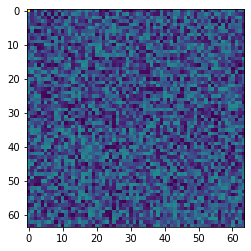

In [89]:
a = np.random.rand(64,64)
a[0][0] = 2
plt.imshow(a)
print(a[0][4])

In [32]:
1e-20

1e-20

In [19]:
labels = np.zeros((2,2,3)) 
labels[0][1][2] = 10
labels = tf.cast(labels, dtype=tf.float32)
output = np.zeros((2,2,3))
output[0][1][2] = 2
output = tf.cast(output, dtype=tf.float32)
weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1

In [20]:
weights

<tf.Tensor: shape=(2, 2, 3), dtype=float32, numpy=
array([[[ 1.,  1.,  1.],
        [ 1.,  1., 82.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.]]], dtype=float32)>

In [22]:
tf.reduce_mean(tf.math.square(labels - output) * weights)

<tf.Tensor: shape=(), dtype=float32, numpy=437.33334>

In [ ]:
mse = tf.keras.losses.MeanSquaredError()
mse(labels, output, sample_weight=tf.cast(labels > 0, dtype=tf.float32) * 81 + 1)

In [47]:
# test para comprobar si el array a con elementos b,b y modificar dichos elementos dentro de una funcion modifica el array
a = []
b = np.random.randint(100, size=(2,2))
a.append((b,b))
print(a)
print(b)
def test(arr):
    for i in range(b.shape[0]):
        b0 = b[i][0]/2
        b1 = b[i][1]/2
        print ('b0:',b0,' b1:',b1)
        b[i] = np.array([b0, b1])
    return "ok"
stri = test(a[0])
print(stri)
print(a)

[(array([[48, 82],
       [86, 47]]), array([[48, 82],
       [86, 47]]))]
[[48 82]
 [86 47]]
b0: 24.0  b1: 41.0
b0: 43.0  b1: 23.5
ok
[(array([[24, 41],
       [43, 23]]), array([[24, 41],
       [43, 23]]))]


In [ ]:
#TEST VERSION
def crop_resize(imagen, joints, scale, margin = 0.2):
    # CROP PART
    xmin = 9999
    ymin = 9999
    xmax = 0
    ymax = 0
    body_height_margin = scale * 200 * margin
    img_height = image.shape[0]
    img_width = image.shape[1]
    for item in joints:
        if item[1] >= 0 and item[1] < xmin : xmin = item[1]
        if item[0] >= 0 and item[0] < ymin : ymin = item[0] 
        if item[1] >= 0 and item[1] > xmax : xmax = item[1]
        if item[0] >= 0 and item[0] > ymax : ymax = item[0]    
    xmin = xmin - body_height_margin
    ymin = ymin - body_height_margin
    xmax = xmax + body_height_margin
    ymax = xmax + body_height_margin
    if xmin < 0: xmin = 0
    if ymin < 0: ymin = 0
    if xmax > img_width: xmax = img_width
    if ymax > img_height: ymax = img_height
    imagen = imagen[ymin:ymax, xmin:xmax, :]
    
    #RESIZE PART
    img_new_height = img.shape[1]
    img_new_width = img.shape[0]
    scala_x = img_new_width / size_img_x
    scala_y = img_new_height / size_img_y
    for i in range(joints.shape[0]): # escala los puntos clave
        joints[i] = np.array([(joints[i][0] - xmin) / scala_x, (joints[i][1] - ymin) / scala_y])            
    imagen = tf.image.resize(imagen,(size_img_x, size_img_y))        
    imagen = imagen/255
    
    return imagen

In [ ]:
#TEST VERSION
def PCKH(valid_images, true_heatmaps):
    
    img_num = validation_images.shape[0]  
    plot_x = np.array([0.1,0.2,0.3,0.4,0.5]) #threshold
    plot_y = np.zeros((16,5))    
      
    for image in range(img_num):
        predicted_joints = predecir_heatmap(validation_images[i]) #array 16x2 lista de coordenadas
        true_joints = get_max(true_heatmaps[i]) #array 16x2 lista de coordenadas originales
        head_bone_size = np.linalg.norm(np.array([true_joints[8][1] - predicted_joints[8][1], true_joints[9][0] - predicted_joints[9][0]]))
        for joint in range(16):
            dif = np.linalg.norm(np.array([true_joints[joint][1] - predicted_joints[joint][1], true_joints[joint][0] - predicted_joints[joint][0]]))
            for rango in range(5):
                 if dif =< plot_x[rango] * head_bone_size:
                    plot_y[joint][rango] += 1
    
    plot_y = plot_y * 100 / img_num

In [139]:
#VERSION OPTIMIZADA
def MakeHeatmapOptimized(x, y, width, height, show = False):
    # Probability as a function of distance from the center derived
    # from a gaussian distribution with mean = 0 and stdv = 1
    scaledGaussian = lambda x : exp(-(1/2)*(x**2))

    imgSize = (height, width)
    center_x = x
    center_y = y

    isotropicGrayscaleImage = np.zeros((imgSize[0],imgSize[1]),np.uint8)
    
    if center_x > 0 and center_y > 0 :
        for i in np.unique(np.clip(np.array(range(center_y-3,center_y+4,1)),0,63)): #solo queremos calcular un parche de 7x7, ademas debemos evitar valores fuera de la matriz, finalmente quitamos valores repetidos
            for j in np.unique(np.clip(np.array(range(center_x-3,center_x+4,1)),0,63)):

                # find euclidian distance from center of image (x,y) 
                # and scale it to range of 0 to 2.5 as scaled Gaussian
                # returns highest probability for x=0 and approximately
                # zero probability for x > 2.5

                distanceFromCenter = np.linalg.norm(np.array([i-center_y,j-center_x]))
                #distanceFromCenter = 18*distanceFromCenter/(imgSize/2)
                scaledGaussianProb = scaledGaussian(distanceFromCenter)                
                isotropicGrayscaleImage[i,j] = np.clip(scaledGaussianProb*255,0,255) 
                
        return isotropicGrayscaleImage
    else: 
        return isotropicGrayscaleImage

In [155]:
###NO ES BUENA IDEA A MENOS QUE QUIERA HACER TODO EL CODIGO EN TF###
def MakeHeatmapTensorflow(x, y, width, height, show = False):
    # Probability as a function of distance from the center derived
    # from a gaussian distribution with mean = 0 and stdv = 1
    scaledGaussian = lambda x : tf.math.exp(tf.math.multiply(-(0.5),tf.math.pow(x,2)))               

    center_x = x
    center_y = y

    isotropicGrayscaleImage = np.zeros((height,width),np.uint8)
    
    if center_x > 0 and center_y > 0 :
        for i in range(height):
            for j in range(width):

                # find euclidian distance from center of image (x,y) 
                # and scale it to range of 0 to 2.5 as scaled Gaussian
                # returns highest probability for x=0 and approximately
                # zero probability for x > 2.5

                distanceFromCenter = tf.norm(tf.cast([i-center_y,j-center_x],dtype=tf.float32),ord='euclidean')
                scaledGaussianProb = scaledGaussian(distanceFromCenter)
                isotropicGrayscaleImage[i,j] = np.clip(scaledGaussianProb*255,0,255)   

        return isotropicGrayscaleImage
    else: 
        return isotropicGrayscaleImage
########################################################################################################################################################

In [156]:
init_t_o = time()
h = MakeHeatmapOptimized(45,12,64,64)
end_t_o = time() - init_t_o

execution time: 0.0030002593994140625


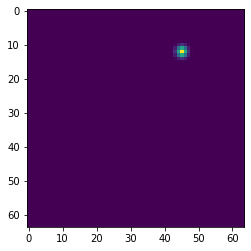

In [157]:
print("execution time:",end_t_o)
plt.imshow(h)

In [164]:
type(round(4.52))

int

## Data Augmentation tests

In [1]:
# example of random rotation image augmentation
import numpy as np
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
import matplotlib.pyplot as plt
%matplotlib inline
# load images
img = np.load('X_train.npy', mmap_mode='r')

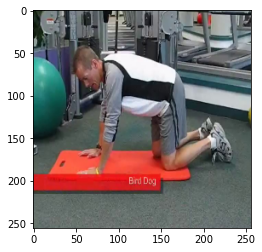

In [23]:
plt.imshow(img[369])

In [33]:
# expand dimension to one sample
samples = expand_dims(img[369], 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30,dtype = 'uint8')

# prepare iterator
it = datagen.flow(samples, batch_size=1)

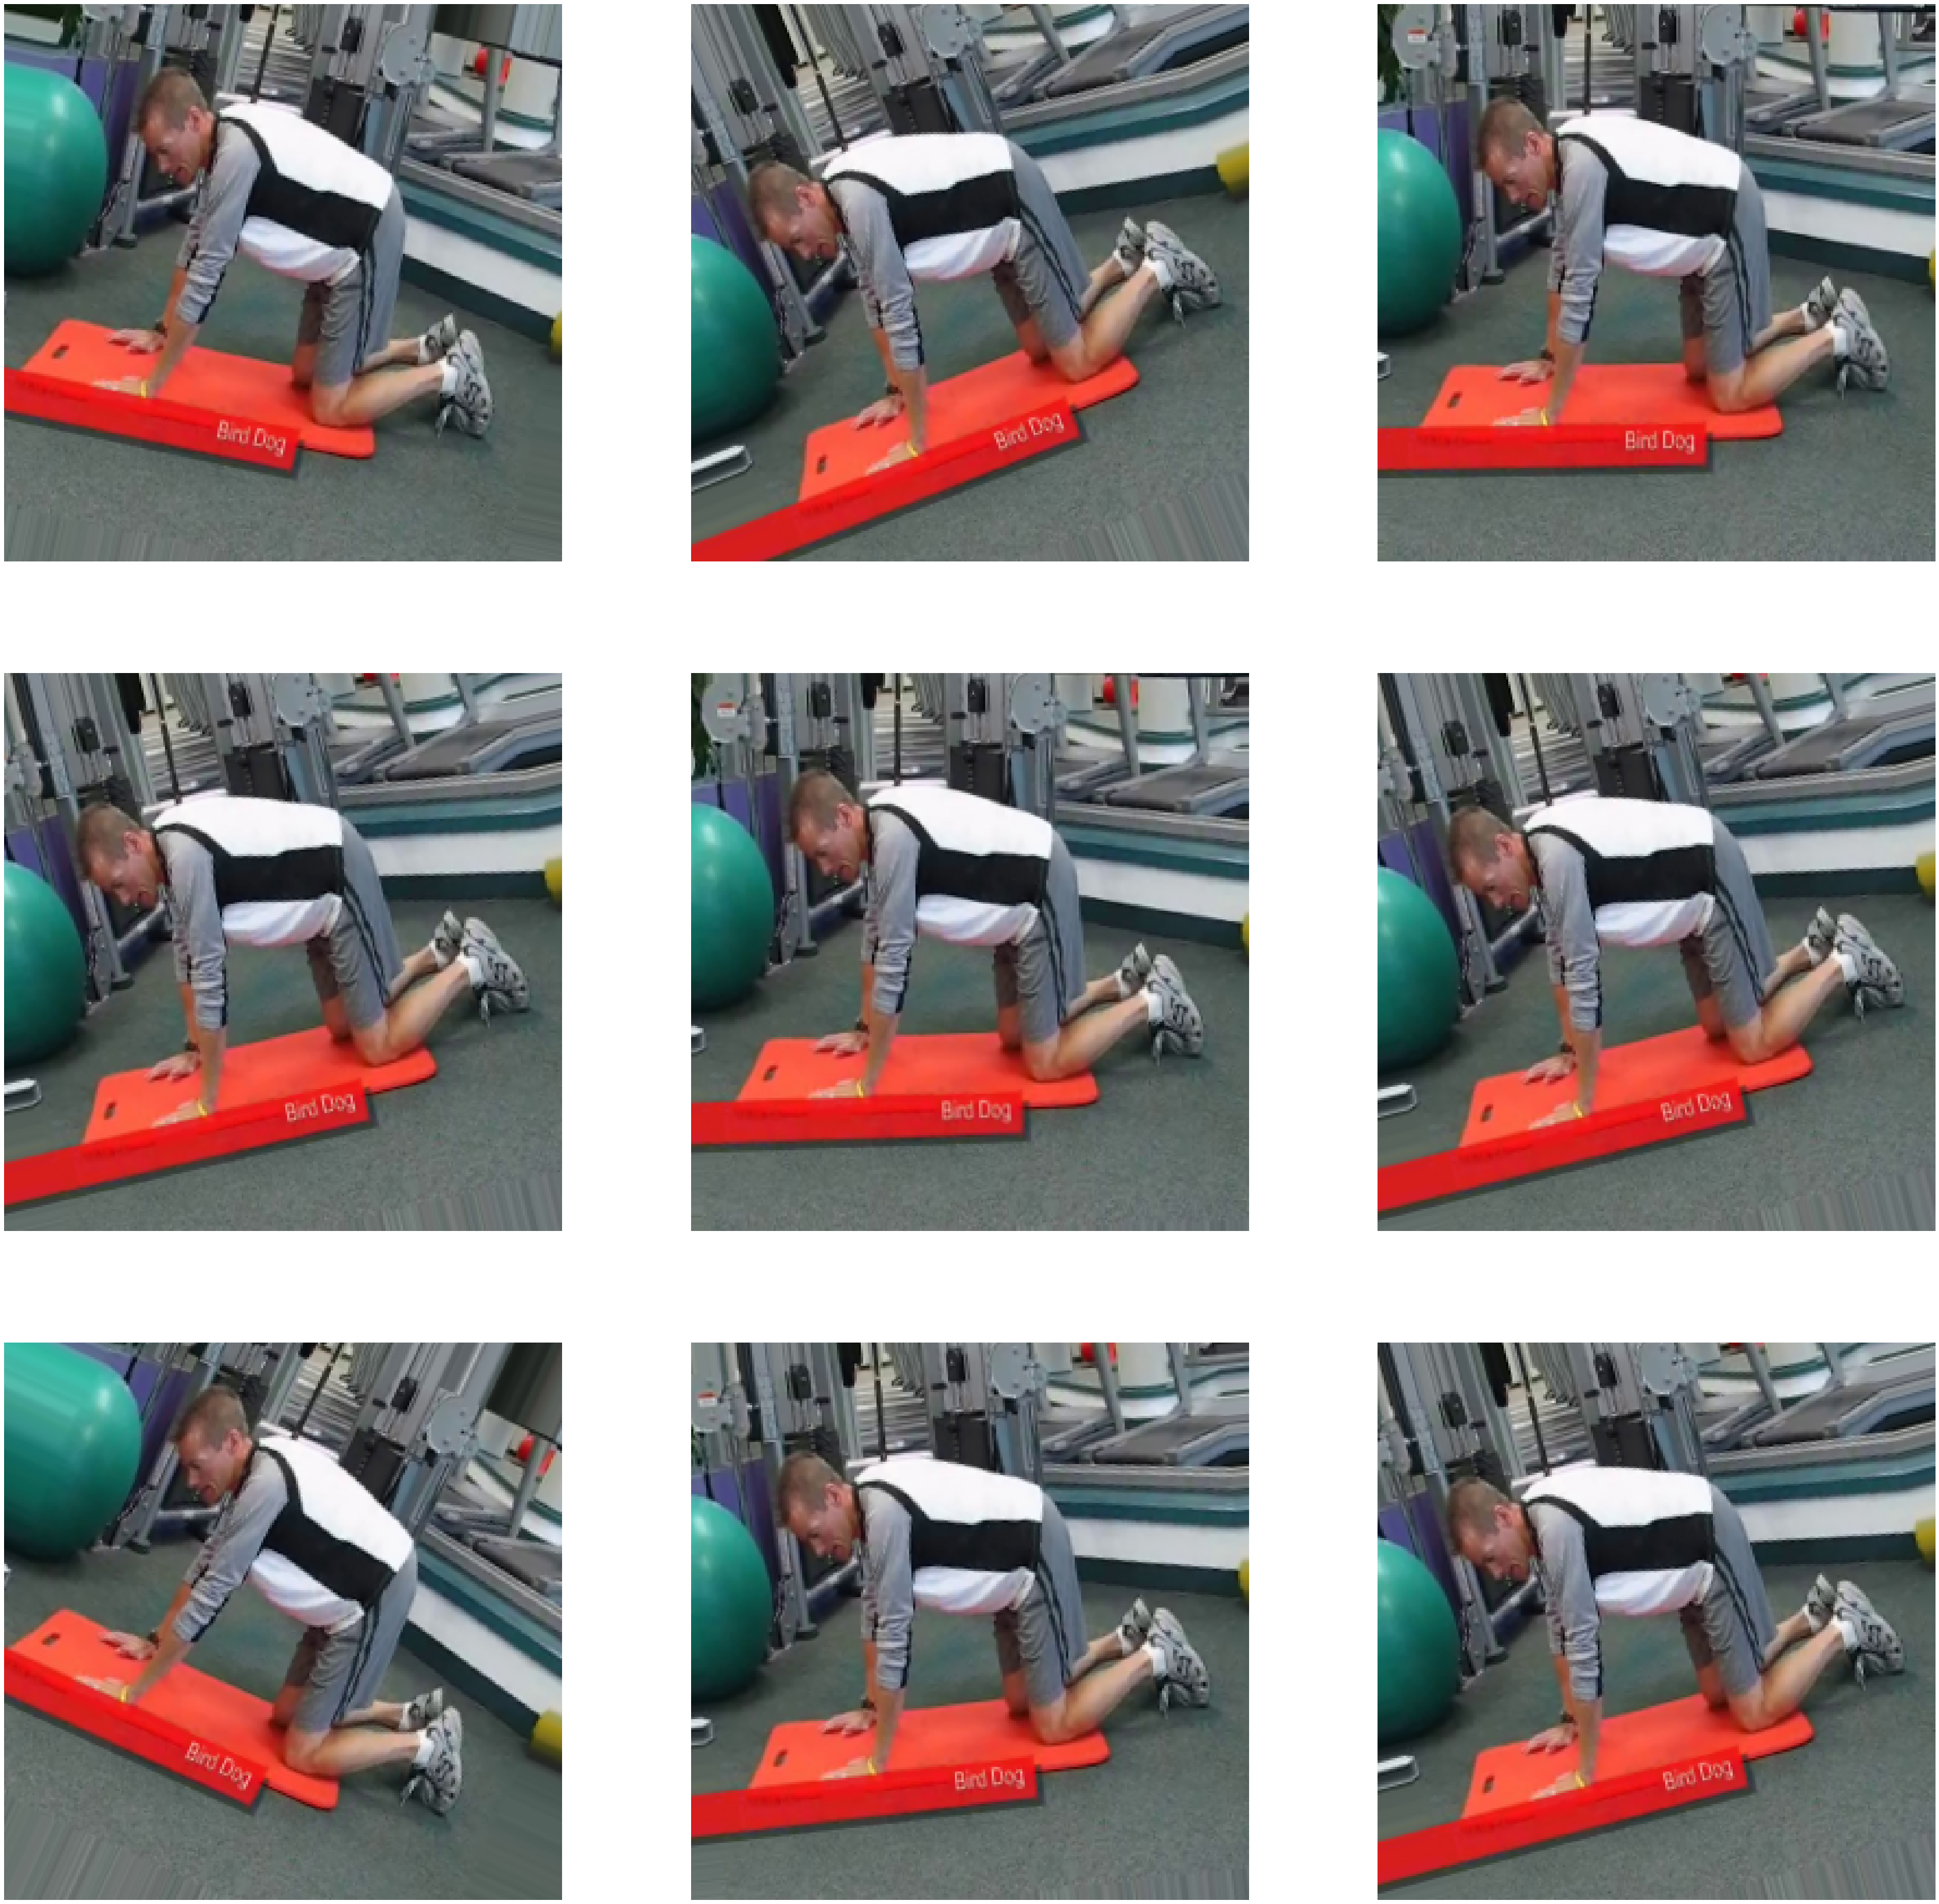

In [35]:
# generate samples and plot
fig, axes = plt.subplots(3, 3, figsize=(60,60))
axes = axes.flatten()
for ax in axes:
    batch = it.next()
    ax.imshow(batch[0])
    ax.axis('off')
#plt.tight_layout()
plt.show()